In [174]:
import numpy as np
from timeit import default_timer as timer

def gambler_value_iteration(head_p=0.25, theta=0.0001, gamma=1.0):
    """
    Value Iteration Algorithm.
    Args:
        head_p: Probability of the coin coming up heads
        theta: We stop evaluation once our value function change is less than delta for all states.
        gamma: Gamma discount factor.
    Returns:
        A tuple (policy, V, iterations) of the optimal policy, the optimal value function, and iterations.
    """
    
    def one_step_lookahead(state, V, rewards):
        """
        Helper function to calculate the value for all action in a given state.
        Args:
            state: The state to consider (int) - Gambler's capital
            V: The value to use as an estimator
            rewards: Reward vector
        Returns:
            A vector of length equals to the number of actions containing the expected value of each action.
        """
        A = np.zeros(101)
        actions = range(1, min(state, 100-state)+1) # Your minimum bet is 1, maximum bet is min(state, 100-state).
        for a in actions:
            # rewards[state+a], rewards[state-a] are immediate rewards.
            # V[state+a], V[state-a] are values of the next states.
            A[a] = head_p * (rewards[state+a] + V[state+a]*gamma) + (1-head_p) * (rewards[state-a] + V[state-a]*gamma)
        return A
    
    # The reward is zero on all transitions except those on which the gambler reaches his goal is +1
    rewards = np.zeros(101)
    rewards[100] = 1
    # Introduces two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros(101)
    
    delta_list = []
    time_list = []
    cum_time_list = []
    total_value_list = []
    iterations = 0
    
    while True:
        start_time = timer()
        iterations += 1
        delta = 0
        for state in range(1,100):
            A = one_step_lookahead(state, V, rewards)  
            best_act_value = np.max(A)
            delta = max(delta, np.abs(best_act_value - V[state]))
            V[state] = best_act_value  # update value to best action value
            
        end_time = timer()
        run_time = end_time - start_time
        delta_list.append(delta)
        time_list.append(run_time)
        cum_time_list.append(sum(time_list))
        total_value_list.append(np.sum(V))
        
        if delta < theta:  # if delta improvement is less than threshold
            break
            
    policy = np.zeros(100)
    for state in range(1,100): 
        A = one_step_lookahead(state, V, rewards)
        best_action = np.argmax(A)
        policy[state] = best_action
        
    return policy, V, iterations, delta_list, time_list, cum_time_list, total_value_list

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

gammas = [1.0, 0.90, 0.80]
head_p_list = [0.4, 0.75]
vi_results = {}
vi_results2 = {}
for gamma in gammas:
    start = timer()
    policy, V, iterations, delta, time, cum_time, total_value = gambler_value_iteration(gamma=gamma)
    end = timer()
    print("Value Iteration: {}s in {} iters with gamma={}, head_p=0.25".format(end - start, iterations, gamma))
    vi_results[gamma] = (policy, V, iterations, delta, time, cum_time, total_value)
    
for head_p in head_p_list:
    start = timer()
    policy, V, iterations, delta, time, cum_time, total_value = gambler_value_iteration(head_p=head_p)
    end = timer()
    print("Value Iteration: {}s in {} iters with gamma=1.0, head_p={}".format(end - start, iterations, head_p))
    vi_results2[head_p] = (policy, V, iterations, delta, time, cum_time, total_value)


Value Iteration: 0.03956706800090615s in 8 iters with gamma=1.0, head_p=0.25
Value Iteration: 0.03707003399904352s in 7 iters with gamma=0.9, head_p=0.25
Value Iteration: 0.03496874500706326s in 7 iters with gamma=0.8, head_p=0.25
Value Iteration: 0.04411962900485378s in 9 iters with gamma=1.0, head_p=0.4
Value Iteration: 0.25999797400436364s in 58 iters with gamma=1.0, head_p=0.75


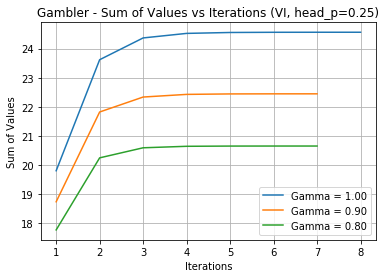

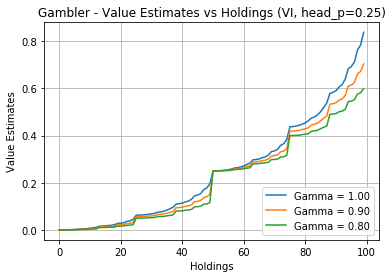

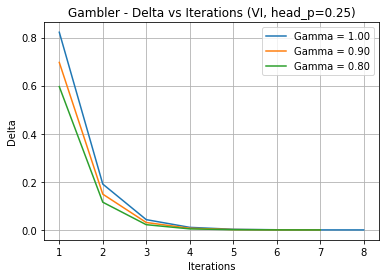

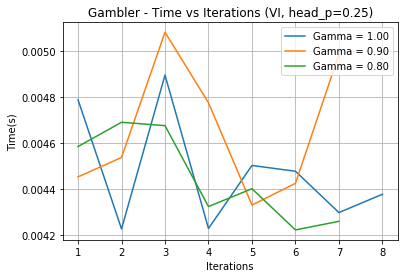

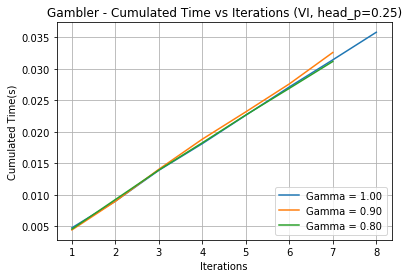

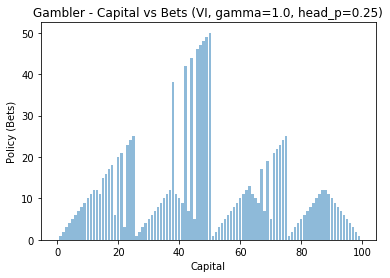

<Figure size 432x288 with 0 Axes>

In [176]:
# Switch plot backend
plt.switch_backend('Agg')
%matplotlib inline

for gamma, results in vi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[6],label=label)
plt.title("Gambler - Sum of Values vs Iterations (VI, head_p=0.25)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Sum of Values')
plt.show()
plt.clf() 

for gamma, results in vi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(100),results[1][:-1],label=label)
plt.title("Gambler - Value Estimates vs Holdings (VI, head_p=0.25)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Holdings')
plt.ylabel('Value Estimates')
plt.show()
plt.clf() 

for gamma, results in vi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[3],label=label)
plt.title("Gambler - Delta vs Iterations (VI, head_p=0.25)")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Delta')
plt.show()
plt.clf() 

for gamma, results in vi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[4],label=label)
plt.title("Gambler - Time vs Iterations (VI, head_p=0.25)")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Time(s)')
plt.show()
plt.clf() 

for gamma, results in vi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[5],label=label)
plt.title("Gambler - Cumulated Time vs Iterations (VI, head_p=0.25)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Cumulated Time(s)')
plt.show()
plt.clf() 

# Plotting Capital vs Final Policy
policy = vi_results[1.0][0]
plt.bar(range(100), policy, align='center', alpha=0.5)
plt.title('Gambler - Capital vs Bets (VI, gamma=1.0, head_p=0.25)')
plt.xlabel('Capital')
plt.ylabel('Policy (Bets)')
plt.show()
plt.clf() 

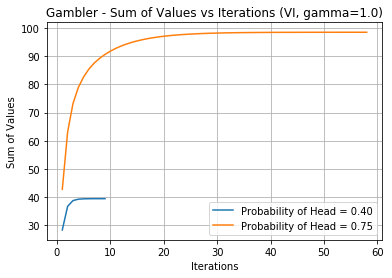

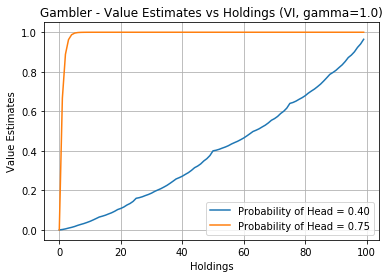

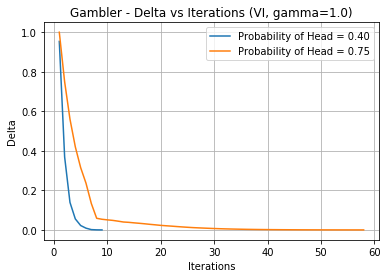

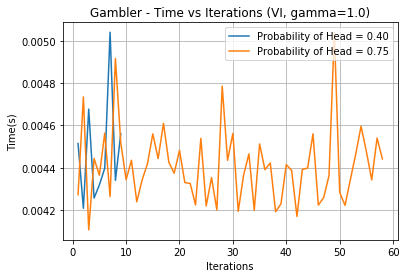

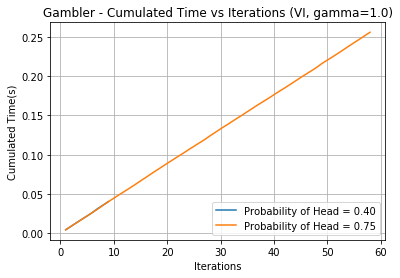

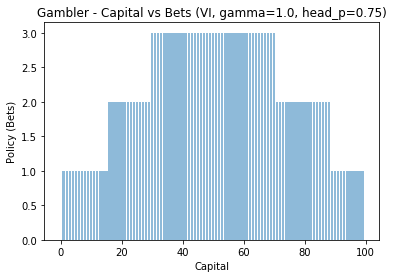

<Figure size 432x288 with 0 Axes>

In [177]:
# Switch plot backend
plt.switch_backend('Agg')
%matplotlib inline

for head_p, results in vi_results2.items():
    label = "Probability of Head = %.2f" %head_p
    plt.plot(range(1, results[2] + 1),results[6],label=label)
plt.title("Gambler - Sum of Values vs Iterations (VI, gamma=1.0)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Sum of Values')
plt.show()
plt.clf() 

for head_p, results in vi_results2.items():
    label = "Probability of Head = %.2f" %head_p
    plt.plot(range(100),results[1][:-1],label=label)
plt.title("Gambler - Value Estimates vs Holdings (VI, gamma=1.0)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Holdings')
plt.ylabel('Value Estimates')
plt.show()
plt.clf() 

for head_p, results in vi_results2.items():
    label = "Probability of Head = %.2f" %head_p
    plt.plot(range(1, results[2] + 1),results[3],label=label)
plt.title("Gambler - Delta vs Iterations (VI, gamma=1.0)")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Delta')
plt.show()
plt.clf() 

for head_p, results in vi_results2.items():
    label = "Probability of Head = %.2f" %head_p
    plt.plot(range(1, results[2] + 1),results[4],label=label)
plt.title("Gambler - Time vs Iterations (VI, gamma=1.0)")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Time(s)')
plt.show()
plt.clf() 

for head_p, results in vi_results2.items():
    label = "Probability of Head = %.2f" %head_p
    plt.plot(range(1, results[2] + 1),results[5],label=label)
plt.title("Gambler - Cumulated Time vs Iterations (VI, gamma=1.0)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Cumulated Time(s)')
plt.show()
plt.clf() 

# Plotting Capital vs Final Policy
policy = vi_results2[0.75][0]
plt.bar(range(100), policy, align='center', alpha=0.5)
plt.title('Gambler - Capital vs Bets (VI, gamma=1.0, head_p=0.75)')
plt.xlabel('Capital')
plt.ylabel('Policy (Bets)')
plt.show()
plt.clf() 

In [178]:
rewards = np.zeros(101)
rewards[100] = 1

def gambler_policy_evaluation(policy, head_p, gamma=1.0, theta=0.00001):
    V = np.zeros(101)
    while True:
        delta = 0
        for s in range(100):
            Vs = 0
            action = int(policy[s])
            Vs += head_p * (rewards[s + action] + gamma * V[s + action]) + (1 - head_p) * (rewards[s - action] + gamma * V[s - action])
            delta = max(delta, np.abs(V[s] - Vs))
            V[s] = Vs
        if delta <= theta:
            break
    return V

def get_q_table(V, state, head_p, gamma):
    actions = np.arange(min(state, 100 - state) + 1)
    q = np.zeros(len(actions))
    for action in actions:
        q[action] += head_p * (rewards[state + action] + gamma * V[state + action]) + (1 - head_p) * (rewards[state - action] + gamma * V[state - action])
    return q

def gambler_policy_improvement(V, head_p, gamma):
    policy = np.zeros(101)
    states = np.arange(101)
    for state in states[1:100]:
        actions = np.arange(min(state, 100 - state) + 1)
        q = get_q_table(V, state, head_p, gamma)
        policy[state] = actions[np.argmax(np.round(q[1:], 5)) + 1]
    return policy

def gambler_policy_iteration(head_p=0.25, gamma=1.0, theta=1e-8):
    policy = np.ones(101)
    
    time_list = []
    cum_time_list = []
    total_value_list = []
    iterations = 0
    
    while True:
        start_time = timer()
        iterations += 1
        V = gambler_policy_evaluation(policy, head_p, gamma, theta)
        new_policy = gambler_policy_improvement(V, head_p, gamma)

        end_time = timer()
        run_time = end_time - start_time
        time_list.append(run_time)
        cum_time_list.append(sum(time_list))
        total_value_list.append(np.sum(V))
        
        if (new_policy == policy).all():
            print((new_policy == policy).all())
            break
        policy = new_policy.copy()
    return policy, V, iterations, time_list, cum_time_list, total_value_list

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

head_p_list = [0.25, 0.4]
pi_results = {}
for head_p in head_p_list:
    start = timer()
    policy, V, iterations, time, cum_time, total_value = gambler_policy_iteration(head_p=head_p)
    end = timer()
    print("Policy Iteration: {}s in {} iters with gamma=1.0, head_p={}".format(end - start, iterations, head_p))
    pi_results[head_p] = (policy, V, iterations, time, cum_time, total_value)

True
Policy Iteration: 0.18160667500342242s in 8 iters with gamma=1.0, head_p=0.25
True
Policy Iteration: 0.4773351679905318s in 7 iters with gamma=1.0, head_p=0.4


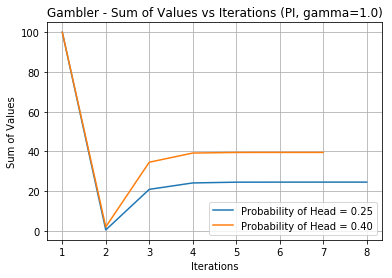

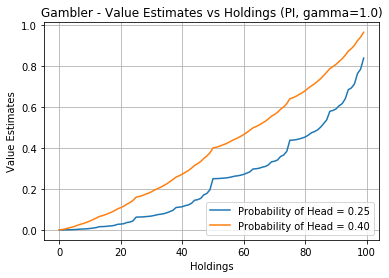

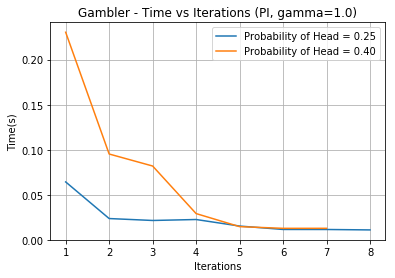

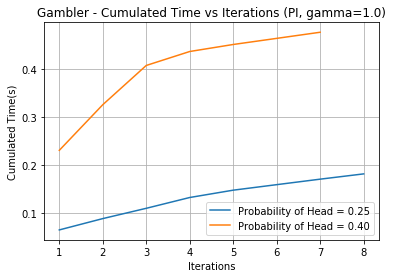

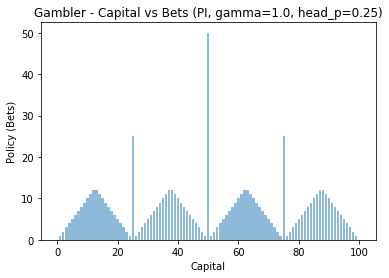

<Figure size 432x288 with 0 Axes>

In [180]:
# Switch plot backend
plt.switch_backend('Agg')
%matplotlib inline

for head_p, results in pi_results.items():
    label = "Probability of Head = %.2f" %head_p
    plt.plot(range(1, results[2] + 1),results[5],label=label)
plt.title("Gambler - Sum of Values vs Iterations (PI, gamma=1.0)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Sum of Values')
plt.show()
plt.clf() 

for head_p, results in pi_results.items():
    label = "Probability of Head = %.2f" %head_p
    plt.plot(range(100),results[1][:-1],label=label)
plt.title("Gambler - Value Estimates vs Holdings (PI, gamma=1.0)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Holdings')
plt.ylabel('Value Estimates')
plt.show()
plt.clf() 

for head_p, results in pi_results.items():
    label = "Probability of Head = %.2f" %head_p
    plt.plot(range(1, results[2] + 1),results[3],label=label)
plt.title("Gambler - Time vs Iterations (PI, gamma=1.0)")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Time(s)')
plt.show()
plt.clf() 

for head_p, results in pi_results.items():
    label = "Probability of Head = %.2f" %head_p
    plt.plot(range(1, results[2] + 1),results[4],label=label)
plt.title("Gambler - Cumulated Time vs Iterations (PI, gamma=1.0)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Cumulated Time(s)')
plt.show()
plt.clf() 

# Plotting Capital vs Final Policy
policy = pi_results[0.25][0]
plt.bar(range(101), policy, align='center', alpha=0.5)
plt.title('Gambler - Capital vs Bets (PI, gamma=1.0, head_p=0.25)')
plt.xlabel('Capital')
plt.ylabel('Policy (Bets)')
plt.show()
plt.clf() 